## Modelo GARCH
$$\varepsilon_t \sim \mathcal{N}(0,\sigma_t)$$
$$\sigma_t = \sqrt{\omega+\alpha_1\sigma_{t-1}^2+\alpha_2\sigma_{t-2}^2...\alpha_q\sigma_{t-p}^2+\beta_1\varepsilon_{t-1}^2+\beta_2\varepsilon_{t-2}^2...+\beta_p\varepsilon_{t-q}^2} = \sqrt{\omega+\sum_{i = 1}^{p}\alpha_i\sigma_{t-i}^2+\sum_{i = 1}^{q}\beta_{t-i}^2}$$

In [1]:
find_best_arch_model <- function(x, 
                                 type_models = "sGARCH", 
                                 dist_to_use = "norm",
                                 max_lag_AR = 2,
                                 max_lag_MA = 2,
                                 max_lag_ARCH = 2,
                                 max_lag_GARCH = 2){
  
  require(tidyr)
  
  df_grid <- expand_grid(type_models = type_models,
                         dist_to_use = dist_to_use,
                         arma_lag = 0:max_lag_AR,
                         ma_lag = 0:max_lag_MA,
                         arch_lag = 1:max_lag_ARCH,
                         garch_lag = 1:max_lag_GARCH)
  
  
  l_out <- pmap(.l = list(x = rep(list(x), nrow(df_grid)), 
                          type_model = df_grid$type_models,
                          type_dist = df_grid$dist_to_use,
                          lag_ar = df_grid$arma_lag,
                          lag_ma = df_grid$ma_lag,
                          lag_arch = df_grid$arch_lag,
                          lag_garch  = df_grid$garch_lag),
                do_single_garch)
  
  tab_out <- bind_rows(l_out)
  
  # find by AIC
  idx <- which.min(tab_out$AIC)
  best_aic <- tab_out[idx, ]
  
  # find by BIC
  idx <- which.min(tab_out$BIC)
  best_bic <- tab_out[idx, ]
  
  l_out <- list(best_aic = best_aic,
                best_bic = best_bic,
                tab_out = tab_out,
                ugspec_b = ugarchspec(variance.model = 
                                      list(model = best_bic$type_model,
                                           garchOrder = c(best_bic$lag_arch, best_bic$lag_garch)),
                                    mean.model = 
                                      list(armaOrder = c(best_bic$lag_ar, best_bic$lag_ma)),
                                    distribution.model = best_bic$type_dist))
  
  return(l_out)
}

In [2]:
do_single_garch <- function(x, 
                            type_model, 
                            type_dist, 
                            lag_ar, 
                            lag_ma, 
                            lag_arch, 
                            lag_garch) {
  require(rugarch)
  
  
  spec = ugarchspec(variance.model = list(model =  type_model, 
                                          garchOrder = c(lag_arch, lag_garch)),
                    mean.model = list(armaOrder = c(lag_ar, lag_ma)),
                    distribution = type_dist)
  
  message('Estimating ARMA(',lag_ar, ',', lag_ma,')-',
          type_model, '(', lag_arch, ',', lag_garch, ')', 
          ' dist = ', type_dist,
          appendLF = FALSE)
  
  try({
    my_rugarch <- list()
    my_rugarch <- ugarchfit(spec = spec, data = x)
  })
  
  if (!is.null(coef(my_rugarch))) {
    message('\tDone')
    
    AIC <- rugarch::infocriteria(my_rugarch)[1]
    BIC <- rugarch::infocriteria(my_rugarch)[2]
  } else {
    message('\tEstimation failed..')
    
    AIC <- NA
    BIC <- NA
  }

  est_tab <- tibble(lag_ar, 
                    lag_ma,
                    lag_arch,
                    lag_garch,
                    AIC =  AIC,
                    BIC = BIC,
                    type_model = type_model,
                    type_dist,
                    model_name = paste0('ARMA(', lag_ar, ',', lag_ma, ')+',
                                        type_model, '(', lag_arch, ',', lag_garch, ') ',
                                        type_dist) ) 
  
  return(est_tab)
}

In [3]:
do_single_dcc <- function(x, uspec, 
                            type_model = "DCC", 
                            type_dist = "mvnorm", 
                            order1, 
                            order2){
  require(rmgarch)
  
  
  spec = dccspec(uspec, dccOrder = c(order1, order2),
                 model = type_model, distribution = type_dist)
  
  message('Estimating DCC(',order1, ',', order2,')-',
          type_model,' dist = ', type_dist,
          appendLF = FALSE)
  
  try({my_rugarch <- list()
    my_rugarch <- dccfit(spec = spec, data = x)})
  if (!is.null(coef(my_rugarch))) {
    message('\tDone')
    AIC <- rugarch::infocriteria(my_rugarch)[1]
    BIC <- rugarch::infocriteria(my_rugarch)[2]
  }else{
    message('\tEstimation failed..')
    AIC <- NA
    BIC <- NA
  }
  est_tab <- tibble(order1 = order1,
                    order2 = order2,
                    AIC =  AIC,
                    BIC = BIC,
                    type_model = type_model,
                    type_dist = type_dist)
  return(est_tab)
}

In [4]:
find_best_dcc_model <- function(x,uspec, 
                                 type_models = "DCC", 
                                 dist_to_use = "mvnorm",
                                 max_order1 = 2,
                                 max_order2 = 2){
  
  require(tidyr)
  
  df_grid <- expand_grid(type_models = type_models,
                         dist_to_use = dist_to_use,
                         order1 = 1:max_order1,
                         order2 = 0:max_order2)
  
  
  l_out <- pmap(.l = list(x = rep(list(x), nrow(df_grid)),
                          uspec = rep(list(uspec), nrow(df_grid)),
                          type_model = df_grid$type_models,
                          type_dist = df_grid$dist_to_use,
                          order1 = df_grid$order1,
                          order2 = df_grid$order2),
                do_single_dcc)
  
  tab_out <- bind_rows(l_out)
  
  # find by AIC
  idx <- which.min(tab_out$AIC)
  best_aic <- tab_out[idx,]
  
  # find by BIC
  idx <- which.min(tab_out$BIC)
  best_bic <- tab_out[idx, ]
  
  l_out <- list(best_aic = best_aic,
                best_bic = best_bic,
                tab_out = tab_out,
                dccspec_b = dccspec(uspec,
                                    dccOrder = c(best_bic$order1, best_bic$order2),
                                    distribution = best_bic$type_dist,
                                    model = best_bic$type_model))
  
  return(l_out)
}

In [5]:
#Funções de risco e de retorno de carteiras
portfolio_sd_t <- function(pesos, cov){
  sd_t <- sqrt(pesos %*% cov %*% pesos)
  return(sd_t)
}
portfolio_return <- function(returns, weight){
  if(!is.vector(returns)){
    mean <- apply(returns,2,mean, na.rm = T)
  } else{
    if(is.vector(returns)){
      mean <- returns
    }
  }
  total_return <- sum(weight*mean)
  return(total_return)
}

In [6]:
#Função de pesos de carteiras
pesos_carteira <- function(n_acoes, n_sim, short = F){
  pesos <- matrix(0,n_acoes,n_sim)
  if(isFALSE(short)){
    pesos <- apply(pesos,2,rexp,0.01)
  }else{
    pesos <- apply(pesos,2,rnorm)
    
  }
  pesos <- apply(pesos,2,function(x)x/sum(x))
  colsub <- apply(pesos,2,function(x)!any(x >= 1| x <= -1))
  pesos <- pesos[,colsub]
  return(pesos)
}

In [8]:
options(warn = -1, scipen = 999)
pacotes <- c("tidyquant","pracma","rmgarch", "tidyverse")
for(i in pacotes){
    suppressPackageStartupMessages({
        library(i, character.only = T)
    })
}

In [99]:
#Ações escolhidas
acoes <- c("IGTA3.SA","LAME4.SA","PETR4.SA")
reta <- tq_get(acoes, from = "2000-01-01") %>%
  group_by(symbol) %>%
  tq_transmute(select = adjusted, mutate_fun = dailyReturn) %>%
  spread(key = symbol, value = daily.returns) %>%
  na.omit

In [100]:
#Pegando o ano, mês e dia da primeira observação
year <- lubridate::year(dplyr::first(reta$date))
month <- lubridate::month(dplyr::first(reta$date))
day <- lubridate::day(dplyr::first(reta$date))

In [101]:
#Transformando em série temporal
reta_ts <- ts(reta[,2:ncol(reta)], start = c(year,month,day), frequency = 252)

In [102]:
lista <- suppressMessages(apply(reta_ts,2,find_best_arch_model,c("sGARCH"),c("norm"),2,2,2,2))
multi <- replicate(ncol(reta_ts),list())

In [103]:
for(i in 1:length(lista)){
  multi[[i]] <- lista[[i]]$ugspec_b
}

In [104]:
multspec <- multispec(multi)
multf <- multifit(multispec = multspec, data = reta_ts)
multfor <- multiforecast(multf, n.ahead = 2)

In [105]:
best <- suppressMessages(find_best_dcc_model(reta_ts, uspec = multspec, dist_to_use = c("mvnorm")))
spec1 <- best$dccspec_b

In [106]:
fit1 <- dccfit(spec1, data = reta_ts, fit = multf, fit.control = list(eval.se = T))
fore <- dccforecast(fit = fit1, n.ahead = 2)

In [107]:
#Usando o µ como retorno esperado
coefs <- numeric(length = ncol(reta_ts))
for(i in 1:length(coefs)){
  coefs[i] <- multf@fit[[i]]@fit$coef["mu"]*252
}

In [108]:
#Matriz de covariância
cov1 <- rcov(fit1)
cov <- cov1[,,dim(cov1)[3]]
cov_f <- rcov(fore)
cov_f <- cov_f[[1]]
cov_f1 <- cov_f[1:ncol(reta_ts),1:ncol(reta_ts),1]
cov_f2 <- cov_f[1:ncol(reta_ts),1:ncol(reta_ts),2]

In [109]:
#Desvio das ações
sd <- sqrt(diag(cov))
sd_f1 <- sqrt(diag(cov_f1))
sd_f2 <- sqrt(diag(cov_f2))
sd_a <- sd*sqrt(252)
sd_a_f1 <- sd_f1*sqrt(252)
sd_a_f2 <- sd_f2*sqrt(252)

In [110]:
#Retorno médio das ações
retornos_a <- tq_get(acoes, from = Sys.Date()-1) %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun= periodReturn, period = "yearly", fill = 0) %>%
  mutate(year = year(date)) %>%
  group_by(year,symbol) %>%
  summarise(yearly.returns) %>%
  spread(key = "symbol", value = "yearly.returns") %>%
  na.fill(fill = 0)

`summarise()` regrouping output by 'year' (override with `.groups` argument)



In [111]:
retorno_med <- retornos_a %>%
  data.frame %>%
  gather(key = "symbol", value = "return", -year) %>%
  group_by(symbol) %>%
  summarise(media = mean(return)) %>%
  spread(key = "symbol", value = "media") %>%
  as.matrix() %>%
  t() %>%
  as.data.frame() %>%
  mutate(Riscos = sd_a_f2)
colnames(retorno_med) <- c("Retorno","Risco")
rownames(retorno_med) <- colnames(reta_ts)
retorno_med$Retorno <- coefs

`summarise()` ungrouping output (override with `.groups` argument)



In [112]:
#Nº de simulações de carteiras a se fazer
n_sim <- 200000
pesos <- pesos_carteira(n_acoes = ncol(reta_ts), n_sim = n_sim, short = F)

In [113]:
#Escolha se prefere o risco atual ou a previsão de risco para 1 período (sd ou sd_f)
start <- Sys.time()
riscos <- apply(pesos, 2, portfolio_sd_t, cov = cov_f2)*sqrt(252)
riscos <- riscos %>% as.matrix
retornos <- apply(pesos, 2, portfolio_return, returns = retorno_med$Retorno) %>% as.matrix
colsub <- apply(riscos,1,function(x)!is.nan(x))
riscos <- riscos[colsub]
retornos <- retornos[colsub]
end <- Sys.time()
end-start

Time difference of 13.68714 secs

## Sharpe
$S = \frac{\mu_c-\mu_r}{\sigma_c}$ onde $\mu_c$ é o retorno da carteira, $\mu_r$ o retorno do ativo livre de risco e $\sigma_c$ é o desvio-padrão da carteira

In [114]:
#Sharpe
tx_livre_risco <- 0.02
data <- matrix(0, nrow = 3, ncol = length(riscos))
data[1,] <- retornos
data[2,] <- riscos
data[3,] <- (retornos-tx_livre_risco)/riscos
rownames(data) <- c("Retornos", "Riscos","Sharpe")
pesos <- pesos[,colsub]
data_d <- as.data.frame(t(data))

In [115]:
#Melhor carteira
inversa <- solve(cov_f2)
pesos_otimo <- inversa %*% (coefs-tx_livre_risco)/sum(inversa %*% (coefs-tx_livre_risco))
ret_otimo <- portfolio_return(coefs,pesos_otimo)
sd_otimo <- portfolio_sd_t(pesos_otimo, cov_f2)*sqrt(252)
sharpe_otimo <- (ret_otimo-tx_livre_risco)/sd_otimo
data_otimo <- data.frame(Retorno = ret_otimo, Risco = sd_otimo, Sharpe = sharpe_otimo)

In [116]:
#Menor Risco
A <- 2*cov_f2
A <- rbind(A, rep(1, ncol(A)))
A <- cbind(A, c(rep(1, nrow(A)-1),0))
b <- c(rep(0,nrow(A)-1),1)
inv_a <- solve(A)
menor_risco <- inv_a %*% b
menor_risco <- menor_risco[-nrow(menor_risco),]
ret_men_risco <- portfolio_return(coefs,menor_risco)
sd_men_risco <- portfolio_sd_t(menor_risco, cov_f2)*sqrt(252)
sharpe_men_risco <- (ret_men_risco-tx_livre_risco)/sd_men_risco
data_men <- data.frame(Retorno = ret_men_risco, Risco = sd_men_risco, Sharpe = sharpe_men_risco)

In [117]:
#Fronteira eficiente (com venda a descoberto)
A1 <- 2*cov_f2
A1 <- rbind(rbind(A1,coefs),rep(1,ncol(A1)))
A1 <- cbind(cbind(A1,c(coefs,rep(0,2))),c(rep(1,nrow(cov_f2)), 0,0))
ymin <- min(coefs)-0.01
ymax <- max(data_otimo$Retorno)+0.01
psb <- c()
dsb <- c()
if(max(coefs) > data_otimo$Retorno+0.01){
    rsb <- seq(ymin,max(coefs)+0.01,l = 2000)
}else{
    rsb <- seq(ymin,ymax,l = 2000)
}
for(i in rsb){
  b <- c(rep(0,ncol(reta_ts)),i,1)
  zb <- solve(A1) %*% b
  w <- zb[1:ncol(reta_ts)]
  psb <- rbind(psb,w)
  dsb <- c(dsb,sqrt(w %*% cov_f2 %*% w)*sqrt(252))
}
fronteira <- data.frame(Retorno = rsb, Risco = dsb)

In [118]:
#Dados Simulados
sharpe <- max(data[3,])
names(sharpe) <- "Sharpe Máximo"
Ret_max <- max(data[1,])
names(Ret_max) <- "Retorno Máximo"
sd_min <- min(data[2,])
names(sd_min) <- "Risco Mínimo"
sharpe
Ret_max
sd_min

Sharpe Máximo 
    0.6323796

Retorno Máximo 
     0.2130551

Risco Mínimo 
   0.2807474

In [119]:
#Melhor carteira simulada
positivo <- data[3,] == sharpe
show(data[,positivo])
pesos_efi <- round(pesos[,positivo],3)
names(pesos_efi) <- colnames(reta_ts)
print(pesos_efi)

 Retornos    Riscos    Sharpe 
0.2129844 0.3051717 0.6323796 
IGTA3.SA LAME4.SA PETR4.SA 
   0.363    0.000    0.637 


In [120]:
#Carteira com menor risco simulado
me <- which.min(data[2,])
show(data[,me])
pesos_m <- round(pesos[,me],3)
names(pesos_m) <- colnames(reta_ts)
print(pesos_m)

 Retornos    Riscos    Sharpe 
0.1732054 0.2807474 0.5457054 
IGTA3.SA LAME4.SA PETR4.SA 
   0.187    0.347    0.466 


In [121]:
retorno_med

,Retorno,Risco
,<dbl>,<dbl>
IGTA3.SA,0.21296572,0.3882869
LAME4.SA,0.09842073,0.3637438
PETR4.SA,0.21305974,0.3345632


In [122]:
#Valores da carteira eficiente com short (ou não)
data_otimo
round(pesos_otimo,3)

Retorno,Risco,Sharpe
<dbl>,<dbl>,<dbl>
0.2301439,0.3288292,0.6390669


IGTA3.SA,0.439
LAME4.SA,-0.149
PETR4.SA,0.710


In [123]:
#Menor risco calculado (com short (ou não))
data_men
print(menor_risco)

Retorno,Risco,Sharpe
<dbl>,<dbl>,<dbl>
0.1731819,0.2807474,0.5456218


 IGTA3.SA  LAME4.SA  PETR4.SA 
0.1863642 0.3477028 0.4659330 


In [124]:
#Correlação entre a melhor carteira calculada e a melhor carteira simulada
corre_s <- (t(pesos_otimo) %*% cov_f2 %*% pesos_efi)/(data[2,positivo]*sd_otimo/252)
colnames(corre_s) <- "Correlação"
corre_s

Correlação
0.9897474


In [125]:
#Correlação entre as carteiras de menor risco simulada e calculada
corre_m <- (menor_risco %*% cov_f2 %*% pesos_m)/(data_men$Risco*sd_min/252)
colnames(corre_m) <- "Correlação"
corre_m

Correlação
0.9999999


In [126]:
#Pesos nas melhores carteiras
cov_m <- matrix(c(data[2,positivo]^2/252, t(pesos_otimo) %*% cov_f2 %*% pesos_efi,
                  t(pesos_otimo) %*% cov_f2 %*% pesos_efi, sd_otimo^2/252), byrow = T,
                nrow = 2)
inve <- solve(cov_m)
p <- inve %*% (c(data[1,positivo], data_otimo$Retorno)-tx_livre_risco)/
  sum(inve %*% (c(data[1,positivo], data_otimo$Retorno)-tx_livre_risco))
rownames(p) <- c("Simulado", "Calculado")
colnames(p) <- "Distribuição das carteiras"
p    

,Distribuição das carteiras
Simulado,-0.01118411
Calculado,1.01118411


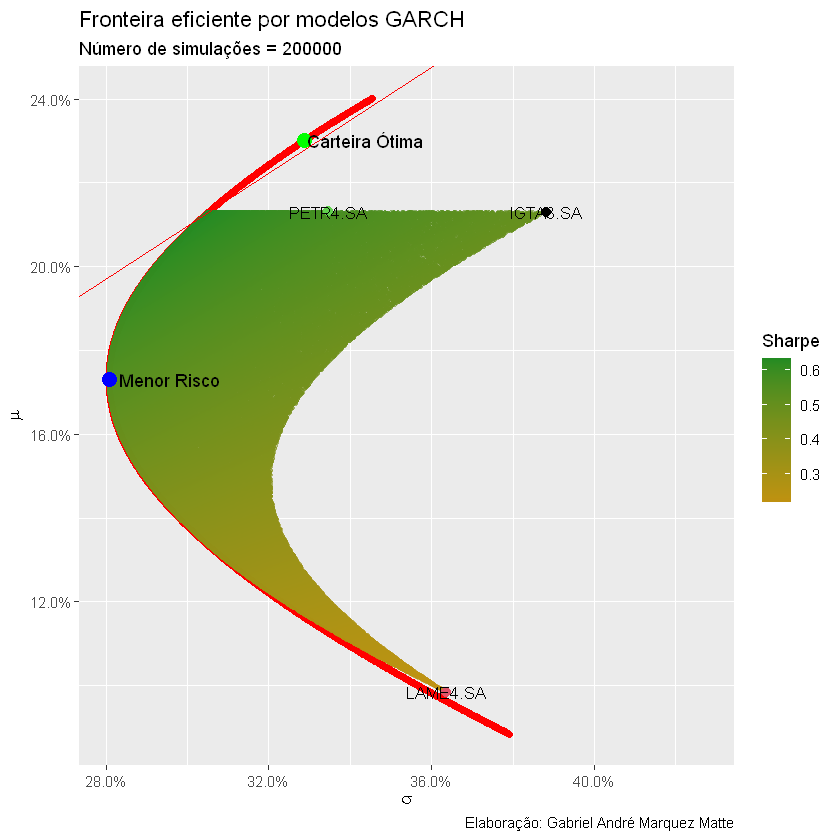

In [127]:
ggplot()+
  geom_point(data = fronteira, aes(x = Risco, y = Retorno), col = "red")+
  geom_point(data = data_d, mapping = aes(x = Riscos, y = Retornos, col = Sharpe), size = 0.7, alpha = 0.4)+
  geom_point(data = retorno_med, aes(x = Risco, Retorno), col = 1:nrow(retorno_med), size = 2.5)+
  geom_text(data = retorno_med, aes(x = Risco, Retorno, label = colnames(reta_ts)),
            size = 3.5)+
  geom_point(data = data_otimo, aes(x = Risco, y = Retorno), col = "green", size = 4)+
  geom_text(data = data_otimo, aes(x = Risco+0.015, Retorno, label = "Carteira Ótima"))+
  geom_point(data = data_men, aes(x = Risco, y = Retorno), col = "blue", size = 4)+
  geom_text(data = data_men, aes(x = Risco+0.015, Retorno, label = "Menor Risco"))+
  geom_abline(slope = max(data[3,]), intercept = tx_livre_risco, col = "red")+
  scale_colour_gradient2(low = "red", high = "forestgreen", mid = "darkorange")+
  labs(x = expression(sigma), y = expression(mu), title = "Fronteira eficiente por modelos GARCH",
       subtitle = paste("Número de simulações =",ncol(pesos)), caption = "Elaboração: Gabriel André Marquez Matte")+
  scale_y_continuous(labels = scales::percent, limits = c(min(fronteira$Retorno), max(rsb)))+
  scale_x_continuous(labels = scales::percent, limits = c(data_men$Risco, max(sd_a_f2)*1.1))